# Library

In [2]:
import pandas as pd
import numpy as np
from numpy import linalg as la
from sklearn.preprocessing import PolynomialFeatures
from matplotlib import pyplot as plt
import seaborn as sns

sns.set_theme()

In [3]:
rng = np.random.default_rng(150)

# Import data & Preprocess

In [4]:
x_read = pd.read_csv("./exercise.csv")
y_read = pd.read_csv("./calories.csv")

x_read = x_read.drop(columns=["User_ID", "Gender"])
y_read = y_read.drop(columns=["User_ID"])

header = x_read.columns

In [5]:
x_read.head()

,Age,Height,Weight,Duration,Heart_Rate,Body_Temp
0,68,190.0,94.0,29.0,105.0,40.8
1,20,166.0,60.0,14.0,94.0,40.3
2,69,179.0,79.0,5.0,88.0,38.7
3,34,179.0,71.0,13.0,100.0,40.5
4,27,154.0,58.0,10.0,81.0,39.8


### Split data

In [6]:
def random_split(x, y):
    assert len(x) == len(y)
    idx_rng = rng.permutation(len(x))

    x_rng = x.iloc[idx_rng].values
    y_rng = y.iloc[idx_rng].values

    train_split = int(0.7 * len(x))
    validate_split = int(0.8 * len(x))

    x_train, x_validate, x_test = np.split(x_rng, [train_split, validate_split])
    y_train, y_validate, y_test = np.split(y_rng, [train_split, validate_split])
    return x_train, x_validate, x_test, y_train, y_validate, y_test


x_train, x_validate, x_test, y_train, y_validate, y_test = random_split(
    x_read, y_read
)

# Basis function

In [7]:
def gaussian_basis_function(x, mu, sigma=0.5):
    return np.exp(-0.5 * (x - mu) ** 2 / sigma**2)


def poly_basis_function(x):
    x = x.reshape(-1, 1)
    tmp = x @ x.T
    i, j = np.tril_indices_from(tmp)
    return tmp[i, j].ravel()


def expand(x):
    return np.concatenate([np.ones((x.shape[0], 1)), x], axis=1)


def get_polynomial_matrix(x):
    power_x = np.apply_along_axis(poly_basis_function, 1, x)
    x_poly = expand(np.concatenate([x, power_x], axis=1))

    return x_poly


def cal_pairwise_dis(x):
    x_cross = x @ x.T
    x_norm = np.repeat(np.diag(x_cross).reshape([1, -1]), x.shape[0], axis=0)
    return np.median(x_norm + x_norm.T - 2 * x_cross)


def get_gaussian_matrix(x, n_centroid=10):
    # Using pairwise distance as sigma
    sigma = cal_pairwise_dis(x)

    x_maxs = np.max(x, axis=0)
    x_mins = np.min(x, axis=0)

    centroids = np.linspace(x_maxs, x_mins, n_centroid, axis=0)

    phi = [
        gaussian_basis_function(x, centroid, sigma) for centroid in centroids
    ]
    phi = np.concatenate(phi, axis=1)

    return expand(phi)

In [8]:
def normalize(x):
    x_maxs = np.max(x, axis=0)
    x_mins = np.min(x, axis=0)

    return (x - x_mins) / (x_maxs - x_mins)


def calMSE(predict: np.ndarray, actual: np.ndarray):
    return np.mean((predict.ravel() - actual.ravel()) ** 2)

# MLR

In [9]:
def MLR(x_train, y_train, x_test, lamda):
    # x_basisMatrix = get_gaussian_matrix(x_train, n_centroid)
    x_phi = get_polynomial_matrix(x_train)
    weight = (
        la.inv(x_phi.T @ x_phi + lamda * np.identity(x_phi.shape[1]))
        @ x_phi.T
        @ y_train
    )

    # y_basisMatrix = get_gaussian_matrix(x_test, n_centroid)
    y_phi = get_polynomial_matrix(x_test)
    return y_phi @ weight

In [10]:
y_MLR = MLR(x_train, y_train, x_test, 10**-10)
print(calMSE(y_MLR, y_test))

19.59264684985922


# BLR

In [11]:
def posterior(phi, t, alpha, beta, return_inverse=False):
    S_N_inv = alpha * np.eye(phi.shape[1]) + beta * phi.T @ phi
    S_N = la.inv(S_N_inv)
    m_N = beta * S_N @ phi.T @ t

    return (m_N, S_N) if not return_inverse else (m_N, S_N, S_N_inv)


def posterior_predictive(phi_test, m_N, S_N, beta):
    y = phi_test @ m_N
    y_var = 1 / beta + phi_test @ S_N @ phi_test.T

    return y, y_var

In [12]:
def fit(phi, t, alpha_0=1e-5, beta_0=1e-5, max_iter=200, rtol=1e-5):
    """
    Jointly infers the posterior sufficient statistics and optimal values
    for alpha and beta by maximizing the log marginal likelihood.

    Args:
        Phi: Design matrix (N x M).
        t: Target value array (N x 1).
        alpha_0: Initial value for alpha.
        beta_0: Initial value for beta.
        max_iter: Maximum number of iterations.
        rtol: Convergence criterion.

    Returns:
        alpha, beta, posterior mean, posterior covariance.
    """

    N, M = phi.shape

    eigenvalues_0 = la.eigvalsh(phi.T.dot(phi))

    beta = beta_0
    alpha = alpha_0

    for i in range(max_iter):
        beta_prev = beta
        alpha_prev = alpha

        eigenvalues = eigenvalues_0 * beta

        m_N, S_N, S_N_inv = posterior(phi, t, alpha, beta, return_inverse=True)

        gamma = np.sum(eigenvalues / (eigenvalues + alpha))
        alpha = gamma / np.sum(m_N**2)

        beta_inv = 1 / (N - gamma) * np.sum((t - phi.dot(m_N)) ** 2)
        beta = 1 / beta_inv

        if np.isclose(alpha_prev, alpha, rtol=rtol) and np.isclose(
            beta_prev, beta, rtol=rtol
        ):
            print(f"Convergence after {i + 1} iterations.")
            return alpha, beta, m_N, S_N

    print(f"Stopped after {max_iter} iterations.")
    return alpha, beta, m_N, S_N


def get_sample(phi_test, m_N, S_N):
    w_samples = rng.multivariate_normal(m_N.ravel(), S_N, 10, "ignore").T

    return phi_test @ w_samples

In [13]:
def BLR(x_train, y_train, x_test):
    phi_train = get_polynomial_matrix(x_train)
    phi_test = get_polynomial_matrix(x_test)

    alpha, beta, m_N, S_N = fit(phi_train, y_train, rtol=10**-5)
    y, y_var = posterior_predictive(phi_test, m_N, S_N, beta)

    y_samples = get_sample(phi_test, m_N, S_N)

    return y, y_samples


y_BLR, y_samples = BLR(x_train, y_train, x_test)

calMSE(y_BLR, y_test)

Convergence after 13 iterations.


19.60038908037948

# Plot figure

In [14]:
def plot_OLS(ax, x, y, c="black", ls="-", label=None):
    dx = np.linspace(x.min(), x.max(), 100)
    m, n = np.polyfit(x, y, 1)
    ax.plot(dx, m * dx + n, c=c, ls=ls, label=label)


def plot_scatter(ax, x, y, label):
    ax.scatter(x, y, s=10, edgecolors="w", linewidths=0.1, label=label)

## MLR plot

In [15]:
def plot_MLR(x, y_truth, y_MLR):
    fig, ax = plt.subplots()
    plot_scatter(ax, x, y_truth, "Observation")
    plot_OLS(ax, x, y_MLR, ls="--", label="OLS fit")
    ax.set_title("MLR Predict")
    ax.set_xlabel("Duration (min)")
    ax.set_ylabel("Calories")
    ax.legend()
    plt.show()

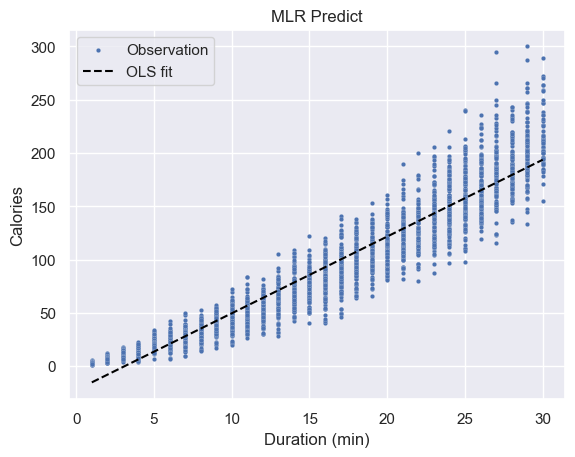

In [16]:
plot_MLR(x_test[:, 3], y_test, y_MLR)

## BLR plot

### Plot sample line

In [17]:
def plot_BLR(x, y_truth, y_BLR, y_sample):
    fig, ax = plt.subplots()
    plot_scatter(ax, x, y_truth, "Observation")

    for sample in y_sample.T:
        plot_OLS(ax, x, sample, c="r", label="Bayesian Posterior Fits")
    plot_OLS(ax, x, y_BLR, ls="--", label="OLS Fit")

    handles, labels = ax.get_legend_handles_labels()
    new_handles, new_labels = [], []

    for handle, label in zip(handles, labels):
        if label not in new_labels:
            new_labels.append(label)
            new_handles.append(handle)

    ax.legend(new_handles, new_labels)
    ax.set_xlabel("Duration (min)")
    ax.set_ylabel("Calories")
    ax.set_title("Posterior Predictions with Limited Observations")
    plt.show()

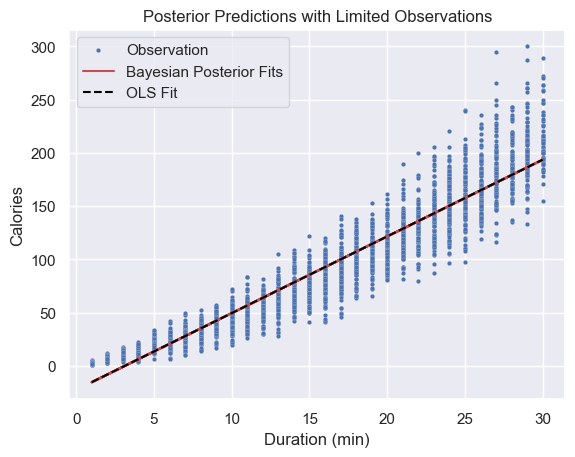

In [18]:
plot_BLR(x_test[:, 3], y_test, y_BLR, y_samples)

# XGBoost

In [20]:
import xgboost as xgb

xgbr_model = xgb.XGBRegressor()
xgbr_model.fit(x_train, y_train)

y_pred = xgbr_model.predict(x_test)
calMSE(y_pred, y_test)

17.400523235076427

# The difference between BLR & MLR

In [109]:
num_observation = 10

In [110]:
y_MLR_single = MLR(
    x_train[:num_observation], y_train[:num_observation], x_test, 0.1
)

y_BLR_single, y_samples_single = BLR(
    x_train[:num_observation], y_train[:num_observation].reshape(-1, 1), x_test
)

Stopped after 200 iterations.


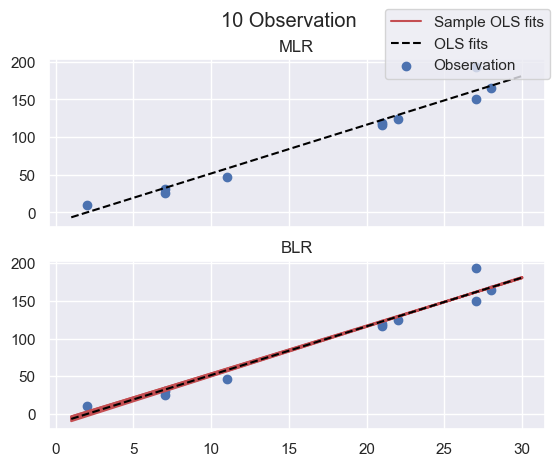

In [111]:
fig, ax = plt.subplots(2, 1, sharex=True, sharey=True)

plot_OLS(ax[0], x_test[:, 3], y_MLR_single, ls="--")
ax[0].scatter(
    x_train[:num_observation, 3], y_train[:num_observation], label="Observation"
)
ax[0].set_title("MLR")


for sample in y_samples_single.T:
    plot_OLS(ax[1], x_test[:, 3], sample, c="r", label="Sample OLS fits")
plot_OLS(ax[1], x_test[:, 3], y_BLR_single, ls="--", label="OLS fits")
ax[1].scatter(
    x_train[:num_observation, 3], y_train[:num_observation], label="Observation"
)
ax[1].set_title("BLR")

handles, labels = ax[1].get_legend_handles_labels()
new_handles, new_labels = [], []

for handle, label in zip(handles, labels):
    if label not in new_labels:
        new_labels.append(label)
        new_handles.append(handle)

fig.legend(new_handles, new_labels, bbox_to_anchor=(0.92, 1))

fig.suptitle(f"{num_observation} Observation")
plt.show()

In [112]:
print(calMSE(y_MLR_single, y_test))
print(calMSE(y_BLR_single, y_test))

226.55146242853135
226.54998348697367
